<a href="https://www.kaggle.com/code/gunrsbelti/ml-1-m-jasdarbs-ga22008?scriptVersionId=225318904" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Autors Gunārs Ābeltiņš, ga22008

### Pamats Jupyter Notebook veidošanai.

1) Koda izpildi kontrolē viens mainīgais - slēdzis  
2) Atkarībā no slēdža stāvokļa, tiek izpildīts tikai modeļa apmācībai vai tikai modeļa pārbaudei nepieciešamais kods  
3) Tiek ielādēti tikai tie moduļi un dati, kas nepieciešami konkrētās darbības izpildei  
4) Ja, pārbaudot kodu, nepieciešams darīt vairāk nekā nomainīt slēdzi un norādīt testa datu kopas ielādes URL, darbs nav korekti pabeigts, notestēts, utt  
5) Pabeigta darba kodam jāstrādā bez aizķeršanās, palaižot to ar Run All  
6) Pēc iespējas visu darbu darīt ar klasēm un funkcijām

### Kontroles bloks
Definē slēdzi un satur saites uz datiem un trenēto modeli

In [1]:
# True - ielādē treniņa datu kopu un uz tās apmāca jaunu modeli, kuru saglabā
# False - ielādē jau apmācītu modeli un atsevišķu datu kopu, uz kuras modeli pārbaudīt
TRAIN = True

# Norādam apmācīta modeļa ielādes URL. Nomainīt.
MODEL_URL = "https://dl.dropbox.com/scl/fi/kkcw1c7ke0dnynnv2sn3h/iris_model.pth?rlkey=gz559t01jm3wtalrjf0clwz9x&st=5wb2xhfd&dl=1"
# Minamālā modeļa URL.
MINIMAL_MODEL_URL = "https://dl.dropbox.com/scl/fi/szsngp0m39erbwmby5e05/minimal_iris_model.pth?rlkey=92nkmamp275e9aub4nqxz2z1x&st=ywosd2ha&dl=1"
# Norādam treniņa datu kopas ielādes URL. Nomainīt.
TRAIN_DATA_URL = 'https://dl.dropbox.com/scl/fi/jcb4bv8g1g2s69a93hmae/Iris_train.csv?rlkey=shqgajvrhpxsw04ptb4nuvgle&dl=1' # <saite uz treniņa datu kopu gdrive, dropbox vai citā serverī>
# Norādam testa datu kopas ielādes URL. Testējot kodu, pagaidām ir validācijas datu kopa, taču pārbaudot darbu pasniedzējs nomainīs uz nodalītu vērtēšanas kopu
TEST_DATA_URL = 'https://dl.dropbox.com/scl/fi/xmsnbuxafq70joj56bcc6/Iris_validate.csv?rlkey=idzjb2shqpypkv23aayajqjsh&dl=1' # <saite uz testa datu kopu gdrive, dropbox vai citā serverī>
# Dropbox gadījumā - padoms tiešās saites iegūšanai https://www.dropboxforum.com/discussions/101001014/public-links-to-raw-files/110391 

### Moduļu importēšana
Importē nepieciešamos moduļus.

In [2]:
# os modulis nepieciešams darbam ar failiem
import os
# torch modulis nodrošina MI apmācībai un lietošanai nepieciešamās funkcijas
import torch
from torch import nn
# numpy modulis nodrošina dažādas matemātiskās funkcijas
import numpy as np
# Pandas modulis tabulveida datu apstrādei
import pandas as pd
# utt.
import torch.utils.data as data
import torch.nn.functional as F

import matplotlib.pyplot as plt

import requests
import io

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# GPU operācijām ir atsevišķs random seed, kas atšķiras no 'standarta' random seed uz CPU vei
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Daļa GPU operāciju var būt ar nedeterminētu secību, kas ļauj apstrādi veikt mazliet ātrāk
# Ar šiem uzstādījumiem to noņem, lai ir reproducējami tie paši rezultāti
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Klašu un funkciju definēšana
Ieteicams visu definēt koda sākumā.  
Komentējiet pašas funkcijas mērķi un galvenās darbības tās iekšienē.  
Ja nepieciešams, definējiet papildus klases un funkcijas.


In [3]:
class IrisDataset(data.Dataset):
    """
    A PyTorch Dataset for the Iris flower dataset.

    This dataset loads iris flower data from a pandas DataFrame and converts it
    into a format suitable for PyTorch models. It handles feature normalization
    and provides a consistent mapping from class names to numerical indices.

    Attributes:
        features (torch.Tensor): Tensor of shape (n_samples, 4) containing the four
            iris features (sepal length, sepal width, petal length, petal width).
        labels (torch.Tensor): Tensor of shape (n_samples,) containing the class
            indices for each sample.
        class_map (dict): Mapping from iris species names to numerical indices.
    """

    def __init__(self, df):
        """
        Initialize the IrisDataset with data from a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing iris data.
                Expected to have the first 4 columns as numerical features
                and the 5th column (index 4) as the class label.
        """
        # Convert feature columns to float
        self.features = torch.tensor(
            df.iloc[:, 0:4].astype(float).values, dtype=torch.float32)

        # Fixed class mapping regardless of data distribution
        self.class_map = {
            'Iris-setosa': 0,
            'Iris-versicolor': 1,
            'Iris-virginica': 2
        }

        # Map labels using the fixed class map
        self.labels = torch.tensor(
            [self.class_map[label] for label in df.iloc[:, 4].values], dtype=torch.long)

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.features)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - features (torch.Tensor): The feature tensor for the sample at index idx.
                - label (torch.Tensor): The class label tensor for the sample at index idx.
        """
        return self.features[idx], self.labels[idx]


class IrisModel(nn.Module):
    """
    A neural network model for classifying Iris flowers.

    This model is a multi-layer perceptron (MLP) with two hidden layers
    and ReLU activations. It's designed to process the four standard Iris
    dataset features and output classification probabilities for the three
    Iris species.

    Attributes:
        linear1 (nn.Linear): First linear layer
        batch_norm1 (nn.BatchNorm1d): Batch normalization after first layer
        dropout1 (nn.Dropout): Dropout layer after first activation
        linear2 (nn.Linear): Second linear layer
        batch_norm2 (nn.BatchNorm1d): Batch normalization after second layer
        dropout2 (nn.Dropout): Dropout layer after second activation
        out (nn.Linear): Output layer
    """
    def __init__(self, in_features=4, h1=16, h2=8, out_features=3, dropout_rate=0.2):
        """
        Initialize the IrisModel with configurable layer sizes.
        
        Args:
            in_features (int): Number of input features (4 for Iris dataset)
            h1 (int): Size of first hidden layer
            h2 (int): Size of second hidden layer
            out_features (int): Number of output classes (3 for Iris dataset)
            dropout_rate (float): Probability of dropping neurons during training
        """
        super().__init__()
        # First hidden layer with batch normalization and dropout
        self.linear1 = nn.Linear(in_features, h1)
        self.batch_norm1 = nn.BatchNorm1d(h1)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second hidden layer with batch normalization and dropout
        self.linear2 = nn.Linear(h1, h2)
        self.batch_norm2 = nn.BatchNorm1d(h2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features)
            
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features)
                          representing class logits
        """
        # First layer with ReLU activation, batch normalization, and dropout
        x = self.linear1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Second layer with ReLU activation, batch normalization, and dropout
        x = self.linear2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Output layer (no activation as we'll use CrossEntropyLoss)
        x = self.out(x)
        
        return x


class MinimalIrisModel(nn.Module):
    """
    A minimal linear model for classifying Iris flowers.

    This model consists of a single linear layer without any hidden layers
    or activation functions. It's designed to provide a simple baseline
    for comparison with more complex models.

    Attributes:
        linear (nn.Linear): Linear layer mapping input features to output classes.
    """

    def __init__(self, in_features=4, out_features=3):
        """
        Initialize the MinimalLinearIrisModel.

        Args:
            in_features (int): Number of input features (4 for Iris dataset)
            out_features (int): Number of output classes (3 for Iris dataset)
        """
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        """
        Forward pass through the linear layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features)
                          representing class logits
        """
        return self.linear(x)


def train(dataframe):
    """
    Train multiple models on the Iris dataset and save the best-performing versions.

    Returns:
        None (Trained models are saved to disk).
    """
    def trainModel(Model, Dataset, epochs, learning_rate, save_path, train_split=0.8):
        """
        Train a given model on a dataset and save the best-performing version.

        Args:
            Model (torch.nn.Module): The neural network model class to be trained.
            Dataset (torch.utils.data.Dataset): The dataset class to be used.
            epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for the optimizer.
            save_path (str): File path to save the best model.
            train_split (float, optional): Ratio of data used for training (default is 0.8).

        Returns:
            None (Saves the best-performing model to the specified path).
        """
        # Create full dataset
        full_dataset = Dataset(dataframe)

        # Calculate split sizes
        dataset_size = len(full_dataset)
        train_size = int(train_split * dataset_size)
        val_size = dataset_size - train_size

        # Split dataset
        train_dataset, val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )

        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=20, shuffle=True)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=val_size, shuffle=False)

        # Initialize model
        model = Model()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_function = nn.CrossEntropyLoss()

        # Track metrics
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        best_train_accuracy = 0

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_epoch_loss = 0
            train_correct = 0
            train_total = 0

            for data_inputs, data_labels in train_loader:
                # Forward pass
                outputs = model(data_inputs)
                loss = loss_function(outputs, data_labels)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track metrics
                train_epoch_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                train_total += data_labels.size(0)
                train_correct += (predicted == data_labels).sum().item()

            # Calculate average training metrics
            avg_train_loss = train_epoch_loss / len(train_loader)
            train_accuracy = 100 * train_correct / train_total
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)

            # Validation phase
            model.eval()
            val_epoch_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for data_inputs, data_labels in val_loader:
                    # Forward pass
                    outputs = model(data_inputs)
                    loss = loss_function(outputs, data_labels)

                    # Track metrics
                    val_epoch_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += data_labels.size(0)
                    val_correct += (predicted == data_labels).sum().item()

            # Calculate average validation metrics
            avg_val_loss = val_epoch_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)

            # Save best model
            if train_accuracy > best_train_accuracy:
                best_train_accuracy = train_accuracy
                torch.save(model.state_dict(), save_path)

            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch+1}/{epochs}")
                print(
                    f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
                print(
                    f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Plot loss and accuracy curves
        epochs_range = range(1, epochs + 1)

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(epochs_range, train_losses, label='Training Loss',
                 marker='o', linestyle='-', markersize=3)
        ax1.plot(epochs_range, val_losses, label='Validation Loss',
                 marker='s', linestyle='-', markersize=3)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Plot accuracies
        ax2.plot(epochs_range, train_accuracies, label='Training Accuracy',
                 marker='o', linestyle='-', markersize=3)
        ax2.plot(epochs_range, val_accuracies, label='Validation Accuracy',
                 marker='s', linestyle='-', markersize=3)
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"Best training accuracy: {best_train_accuracy:.2f}%")
        print(f"Model saved to {save_path}")

    print("Training model...")

    trainModel(IrisModel, IrisDataset, 200, 0.01, "iris_model.pth")

    print("Training minimal model...")

    trainModel(MinimalIrisModel, IrisDataset,
               200, 0.01, "minimal_iris_model.pth")

    print("Training complete.")


def test(dataframe):
    """
    Test pre-trained models on a test dataset and evaluate their accuracy.

    This function defines helper functions for downloading model weights and 
    testing models on the Iris dataset. If training is disabled (`TRAIN == False`), 
    it downloads model weights before testing.

    Returns:
        None
    """

    def download_weights_from_url(url, save_path):
        """
        Download model weights from a given URL and save them to a file.

        Args:
            url (str): The URL to download the weights from.
            save_path (str): The local file path to save the downloaded weights.

        Returns:
            bool: True if download was successful, False otherwise.
        """
        print(f"Downloading model weights from {url}...")
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise exception for HTTP errors

            # Save the downloaded content to a file
            with open(save_path, 'wb') as f:
                f.write(response.content)
            print(f"Successfully downloaded weights to {save_path}")

        except Exception as e:
            print(f"Error downloading weights: {e}")
            return False

        return True

    def testModel(ModelClass, model_path):
        """
        Load and evaluate a trained model on the test dataset.

        Args:
            ModelClass (torch.nn.Module): The model class to be tested.
            model_path (str): The file path of the saved model weights.

        Returns:
            None (Prints classification results and model accuracy).
        """
        print(f"Testing {ModelClass.__name__} model...")

        # Load test dataset
        test_dataset = IrisDataset(dataframe)
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=1, shuffle=False)

        class_map = test_dataset.class_map

        # Create reverse class map
        reverse_class_map = {v: k for k, v in class_map.items()}

        # Load trained model
        model = ModelClass()
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model.eval()  # Set model to evaluation mode

        correct = 0
        total = len(test_dataset)

        with torch.no_grad():
            for idx, (inputs, true_label) in enumerate(test_loader):
                outputs = model(inputs)
                predicted_idx = torch.argmax(outputs, dim=1).item()

                # Get class names using reverse mapping
                predicted_class = reverse_class_map[predicted_idx]
                true_class = reverse_class_map[true_label.item()]

                correct_prediction = predicted_class == true_class
                correctness_text = "correct" if correct_prediction else "incorrect"
                print(
                    f"Row {idx + 1}: Predicted class: {predicted_class}; Actual class: {true_class}, {correctness_text}")

                if correct_prediction:
                    correct += 1


        accuracy = (correct / total) * 100
        print(f"Precision: {accuracy:.0f}% ({correct}/{total})")

    if TRAIN == False:
        # Download model weights from URLs if in testing mode
        # For the normal model
        download_weights_from_url(MODEL_URL, "iris_model.pth")
        # For the minimal model
        download_weights_from_url(MINIMAL_MODEL_URL, "minimal_iris_model.pth")

    print("Testing normal model...")
    testModel(IrisModel, "iris_model.pth")
    print("Testing minimal model...")
    testModel(MinimalIrisModel, "minimal_iris_model.pth")

### Datu ielādes bloks
Šajā koda blokā ielādē nepieciešamo datu kopa un sagatavo darbam ar modeli

In [4]:
if TRAIN == True:
    print("Ielādē treniņa datu kopu")
    # NB! Kaggle Settings jābūt 'Turn On Internet', savādāk no tīkla neko nevarēs ielādēt, būs kļūda 'Temporary failure in name resolution' 
    iris_dataframe = pd.read_csv(TRAIN_DATA_URL)
    
else:
    print("Ielādē testa datu kopu")
    iris_dataframe = pd.read_csv(TEST_DATA_URL)

iris_dataframe

Ielādē treniņa datu kopu


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
121,6.4,3.1,5.5,1.8,Iris-virginica
122,6.0,3.0,4.8,1.8,Iris-virginica
123,6.9,3.1,5.4,2.1,Iris-virginica
124,6.7,3.1,5.6,2.4,Iris-virginica


### Modeļa apmācīšanas bloks
Šis bloks tiek palaists tikai tad, ja TRAIN == True.  
Satur tikai funkciju train.

Training model...
Epoch: 10/200
  Train Loss: 0.3518, Train Acc: 88.00%
  Val Loss: 0.3214, Val Acc: 96.15%
Epoch: 20/200
  Train Loss: 0.1668, Train Acc: 95.00%
  Val Loss: 0.2812, Val Acc: 88.46%
Epoch: 30/200
  Train Loss: 0.1430, Train Acc: 97.00%
  Val Loss: 0.2277, Val Acc: 92.31%
Epoch: 40/200
  Train Loss: 0.2130, Train Acc: 93.00%
  Val Loss: 0.2081, Val Acc: 92.31%
Epoch: 50/200
  Train Loss: 0.1604, Train Acc: 95.00%
  Val Loss: 0.1785, Val Acc: 88.46%
Epoch: 60/200
  Train Loss: 0.1671, Train Acc: 93.00%
  Val Loss: 0.1748, Val Acc: 92.31%
Epoch: 70/200
  Train Loss: 0.1950, Train Acc: 93.00%
  Val Loss: 0.1738, Val Acc: 92.31%
Epoch: 80/200
  Train Loss: 0.1683, Train Acc: 92.00%
  Val Loss: 0.2015, Val Acc: 96.15%
Epoch: 90/200
  Train Loss: 0.3526, Train Acc: 94.00%
  Val Loss: 0.3622, Val Acc: 80.77%
Epoch: 100/200
  Train Loss: 0.1663, Train Acc: 94.00%
  Val Loss: 0.2291, Val Acc: 92.31%
Epoch: 110/200
  Train Loss: 0.2120, Train Acc: 91.00%
  Val Loss: 0.2975, Val Ac

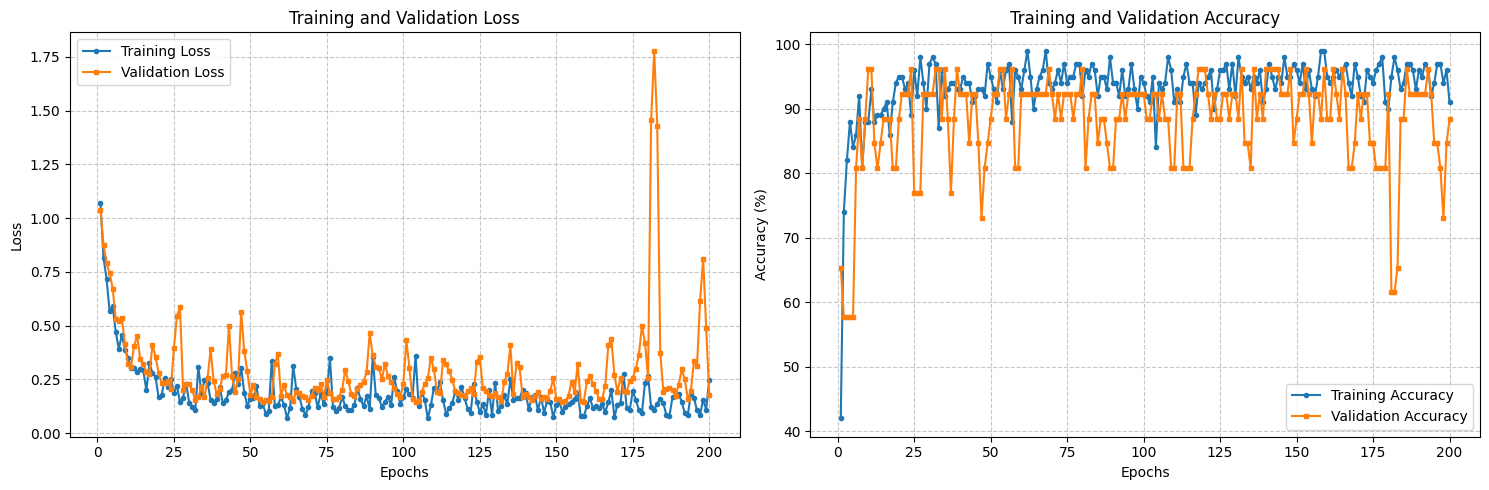

Best training accuracy: 99.00%
Model saved to iris_model.pth
Training minimal model...
Epoch: 10/200
  Train Loss: 1.0517, Train Acc: 41.00%
  Val Loss: 1.0704, Val Acc: 38.46%
Epoch: 20/200
  Train Loss: 0.7990, Train Acc: 63.00%
  Val Loss: 0.6899, Val Acc: 80.77%
Epoch: 30/200
  Train Loss: 0.6648, Train Acc: 75.00%
  Val Loss: 0.5279, Val Acc: 100.00%
Epoch: 40/200
  Train Loss: 0.5809, Train Acc: 82.00%
  Val Loss: 0.4341, Val Acc: 100.00%
Epoch: 50/200
  Train Loss: 0.5195, Train Acc: 93.00%
  Val Loss: 0.3643, Val Acc: 100.00%
Epoch: 60/200
  Train Loss: 0.4786, Train Acc: 95.00%
  Val Loss: 0.3080, Val Acc: 96.15%
Epoch: 70/200
  Train Loss: 0.4402, Train Acc: 96.00%
  Val Loss: 0.2877, Val Acc: 100.00%
Epoch: 80/200
  Train Loss: 0.4109, Train Acc: 94.00%
  Val Loss: 0.2789, Val Acc: 100.00%
Epoch: 90/200
  Train Loss: 0.3828, Train Acc: 96.00%
  Val Loss: 0.2484, Val Acc: 100.00%
Epoch: 100/200
  Train Loss: 0.3599, Train Acc: 97.00%
  Val Loss: 0.2344, Val Acc: 100.00%
Epoch

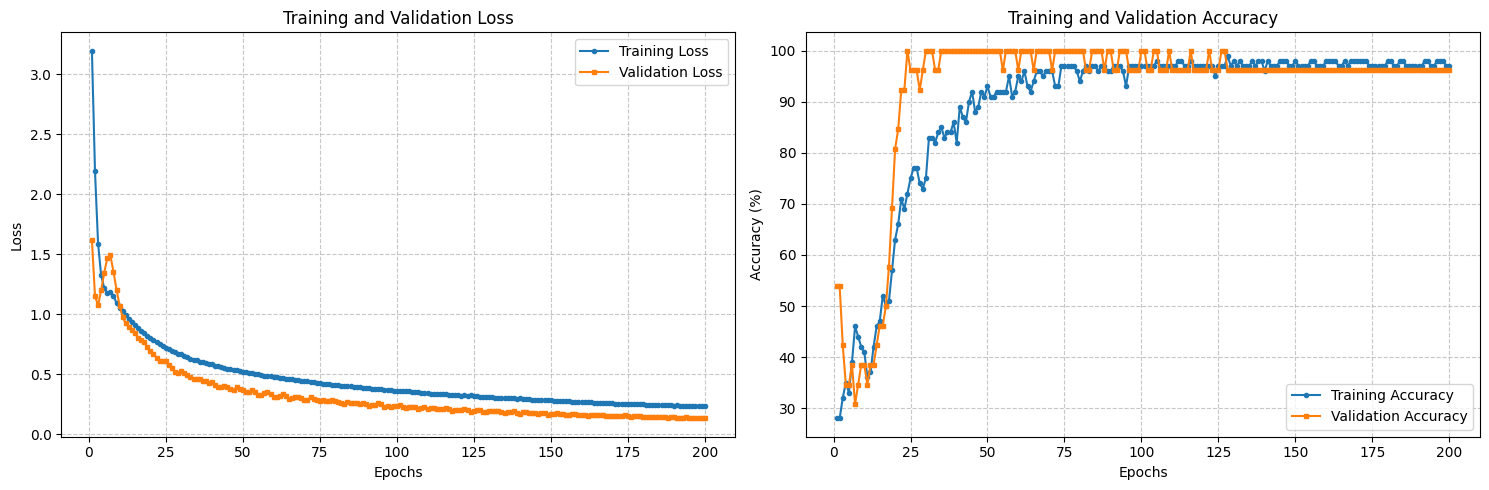

Best training accuracy: 99.00%
Model saved to minimal_iris_model.pth
Training complete.


In [5]:
if TRAIN == True:
    train(iris_dataframe)

### Modeļa pārbaudes kods
Šis bloks tiek palaists jebkurā gadījumā. Visiem iepriekšējiem blokiem jānostrādā pareizi atkarībā no TRAIN stāvokļa, lai šis kods paņemtu no jauna uztrenētu modeli un pārbaudīto to uz validācijas datu kopas, vai ielādētu saglabātu modeli un pārbaudītu to uz testa datu kopas.

Testa palaišanai jāizdrukā:
1. visu pārbaužu rezultāti viegli saprotamā formā (12 rindiņas, pa vienai katram validācijas kopas piemēram)
2. kopējais precizitātes novērtējums.
   
Paraugs iespējamam adekvātam noformējumam:

- 1\. datu rindiņā klasifikatora rezultāts: Iris-setosa; reālā suga: Iris-setosa, pareizi
- 2\. datu rindiņā klasifikatora rezultāts: Iris-versicolor; reālā suga: Iris-setosa, nepareizi
- ...
- 12\. datu rindiņā klasifikatora rezultāts: Iris-virginica; reālā suga: Iris-virginica, pareizi
    Precizitāte: 58% (7/12)


In [6]:
test(iris_dataframe)

Testing normal model...
Testing IrisModel model...
Row 1: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 2: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 3: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 4: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 5: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 6: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 7: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 8: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 9: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 10: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 11: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 12: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 13: Predicted class: Iris-setosa; Actual class: Iris-setosa, correct
Row 14: P